Họ tên: Lê Hoàng Đức

MSSV: 18110075



**Câu 1: Giải thích vì sao khi dùng Naive-Learning thì xe taxi chỉ đứng yên một chỗ?**

**Trả lời:** Thực ra taxi vẫn có di chuyển khi dùng Naive-Learning. Bởi vì quá trình khởi tạo có thể khiến xe rơi vào vị trí không thể di chuyển tiếp (ngõ cụt), lúc này xe vẫn giữ vị trí cũ, tuy nhiên reward vẫn được nhận cho action này. Điều này bắt nguồn từ việc random các action ban đầu khiến xe thực hiện sai (đón và trả khách) nên các giá trị reward rất nhỏ dẫn đến ở các bước sau, agent sẽ không chọn các action này thay vào đó là các action di chuyển.

**Câu 2: Giải thích vì sao khi dùng Q-Leaning thì xe taxi có thể đón và trả khách được?**

**Trả lời:** Q-Learning không giống như Naive-Learning. Q-Learning tìm ra các action tối ưu ở mỗi state. Do vậy không bị tình trạng chọn đại (random) như Naive-Learning. Ngoài ra, các cơ chế update Q-Value bằng các hệ số discount rate, learning rate làm cho các Q-Value luôn có sự chênh lệch nhất định, không bị trùng giá trị, dễ dàng tìm ra action tối ưu tại mỗi state.

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

In [ ]:
import numpy as np
import gym
import time
from IPython.display import clear_output
from IPython import display
%matplotlib inline

In [ ]:
import math
import matplotlib.pyplot as plt
from gym import wrappers

# CREATE ENVIRONMENT
env = gym.make('Pendulum-v0')
n_actions = env.action_space.shape[0]
n_states = env.observation_space.shape[0]
print("Action space size: ", n_actions)
print("State space size: ", n_states)

print('Action boundaries:', env.action_space.high, env.action_space.low)
print('State boundaries:', env.observation_space.high, env.observation_space.low)


Action space size:  1
State space size:  3
Action boundaries: [2.] [-2.]
State boundaries: [1. 1. 8.] [-1. -1. -8.]


In [ ]:
# HYPERPARAMETERS
n_episodes = 1000           # Total train episodes
n_steps = 200               # Max steps per episode
min_alpha = 0.06             
min_epsilon = 0.01           
gamma = 0.91                # discount factor
decay_epsilon = 3  
decay_alpha = 23   

action_buckets = 2 
state_buckets = (13, 11, 12) 

ub_action = env.action_space.high # upper bound of action
lb_action = env.action_space.low # lower bound of action
 
ub_state = env.observation_space.high 
lb_state = env.observation_space.low



In [ ]:

def discretize(obs, lower_bounds, upper_bounds, buckets):
    ''' discretise the continuous state into buckets ''' 
    ratios = [(obs[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(obs))]
    new_obs = [int(round((buckets[i] - 1) * ratios[i])) for i in range(len(obs))]
    new_obs = [min(buckets[i] - 1, max(0, new_obs[i])) for i in range(len(obs))]
    return tuple(new_obs)

def discretize_action(action, lower_bounds, upper_bounds, buckets):
    ''' discretise the continuous action into buckets ''' 
    ratios = (action + abs(lower_bounds)) / (upper_bounds - lower_bounds)
    new_action = int(np.round((buckets - 1) * ratios))
    new_action = min(buckets - 1, max(0, new_action))
    res = (new_action,)  
    return res

def convert_action_to_float(x):
    """ 
    x is a int between 0 and 4. The function scale x between -2 and 2. 
    """
    OldMax = action_buckets-1 
    OldMin = 0
    NewMax = 2
    NewMin = -2

    OldRange = (OldMax - OldMin)  
    NewRange = (NewMax - NewMin)  
    y = (((x - OldMin) * NewRange) / OldRange) + NewMin
    res = [y] 
    return res

def epsilon_policy(state, epsilon):
    ''' choose an action using the epsilon policy '''
    exploration_exploitation_tradeoff = np.random.random()
    if exploration_exploitation_tradeoff <= epsilon:
        action = env.action_space.sample()  # exploration
    else:
        discrete_action = np.argmax(Q[state])   # exploitation
        action = convert_action_to_float(discrete_action)
    return action

def greedy_policy(state):
    ''' choose an action using the greedy policy '''
    discrete_action = np.argmax(Q[state])  
    action = convert_action_to_float(discrete_action)
    return action

def update_q(current_state, action, reward, new_state, alpha):
    ''' update the Q table with the Bellman equation '''
    current_state_action_pair = current_state + action
    Q[current_state_action_pair] += alpha * (reward + gamma * np.max(Q[new_state]) - Q[current_state_action_pair])

def get_epsilon(t):
    ''' decrease the exploration rate at each episode '''
    return max(min_epsilon, min(1, 1.0 - math.log10((t + 1) / decay_epsilon)))

def get_alpha(t):
    ''' decrease the learning rate at each episode '''
    return max(min_alpha, min(1.0, 1.0 - math.log10((t + 1) / decay_alpha)))


In [ ]:
# INITIALISE Q TABLE
Q = np.zeros(state_buckets + (action_buckets,)) 
print(Q.shape)

# TRAINING PHASE
rewards = [] 

for episode in range(n_episodes):
    current_state = env.reset()
    current_state = discretize(current_state, lb_state, ub_state, state_buckets)

    alpha = get_alpha(episode)
    epsilon = get_epsilon(episode)

    episode_rewards = 0

    for t in range(n_steps):
        # env.render()
        action = epsilon_policy(current_state, epsilon)
        new_state, reward, done, _ = env.step(action)
        new_state = discretize(new_state, lb_state, ub_state, state_buckets)
        action = discretize_action(action, lb_action, ub_action, action_buckets)
        update_q(current_state, action, reward, new_state, alpha)
        current_state = new_state

        # increment the cumulative reward
        episode_rewards += reward

        # at the end of the episode
        if done:
            print('episode: {0:d}/{1:d} | Reward: {2:08.02f} | Epsilon: {3:.2f} | Alpha: {4:.2f}'.format(episode, n_episodes, episode_rewards, epsilon, alpha))
            break

    # append the episode cumulative reward to the reward list
    rewards.append(episode_rewards)

(13, 11, 12, 2)
episode: 0/1000 | Reward: -0996.26 | Epsilon: 1.00 | Alpha: 1.00
episode: 1/1000 | Reward: -0774.52 | Epsilon: 1.00 | Alpha: 1.00
episode: 2/1000 | Reward: -1255.81 | Epsilon: 1.00 | Alpha: 1.00
episode: 3/1000 | Reward: -1073.23 | Epsilon: 0.88 | Alpha: 1.00
episode: 4/1000 | Reward: -1666.73 | Epsilon: 0.78 | Alpha: 1.00
episode: 5/1000 | Reward: -1059.79 | Epsilon: 0.70 | Alpha: 1.00
episode: 6/1000 | Reward: -1171.84 | Epsilon: 0.63 | Alpha: 1.00
episode: 7/1000 | Reward: -1446.72 | Epsilon: 0.57 | Alpha: 1.00
episode: 8/1000 | Reward: -1295.87 | Epsilon: 0.52 | Alpha: 1.00
episode: 9/1000 | Reward: -1535.68 | Epsilon: 0.48 | Alpha: 1.00
episode: 10/1000 | Reward: -1175.36 | Epsilon: 0.44 | Alpha: 1.00
episode: 11/1000 | Reward: -1568.87 | Epsilon: 0.40 | Alpha: 1.00
episode: 12/1000 | Reward: -0960.45 | Epsilon: 0.36 | Alpha: 1.00
episode: 13/1000 | Reward: -1022.76 | Epsilon: 0.33 | Alpha: 1.00
episode: 14/1000 | Reward: -1490.90 | Epsilon: 0.30 | Alpha: 1.00
epis

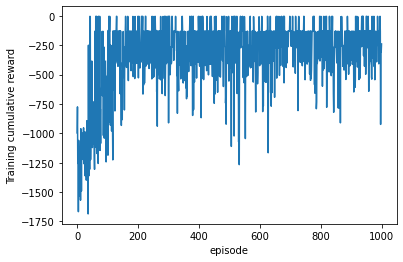

In [ ]:
# PLOT RESULTS
x = range(n_episodes)
plt.plot(x, rewards)
plt.xlabel('episode')
plt.ylabel('Training cumulative reward')
plt.savefig('Q_learning_pendulum.png', dpi=300)
plt.show()

In [ ]:
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [ ]:
# TEST PHASE
env = wrap_env(env)
total_test_episodes = 30
rewards = []
for e in range(total_test_episodes):

    current_state = env.reset()
    current_state = discretize(current_state, lb_state, ub_state, state_buckets)
    episode_rewards = 0

    for t in range(n_steps):
        action = greedy_policy(current_state)
        new_state, reward, done, _ = env.step(action)
        env.render()
        # print('reward: ', reward)
        clear_output(wait=True)
        new_state = discretize(new_state, lb_state, ub_state, state_buckets)
        action = discretize_action(action, lb_action, ub_action, action_buckets)
        update_q(current_state, action, reward, new_state, alpha)
        current_state = new_state
        episode_rewards += reward

        # at the end of the episode
        if done:
            rewards.append(episode_rewards)
            print('Test episode finished with a total reward of: {:.2f}'.format(episode_rewards))
            break

env.close()
print ("Score over time: " +  str(sum(rewards)/total_test_episodes))
show_video()

Test episode finished with a total reward of: -136.73
Score over time: -232.13480172890502
